Loading cached camera calibration... Done.


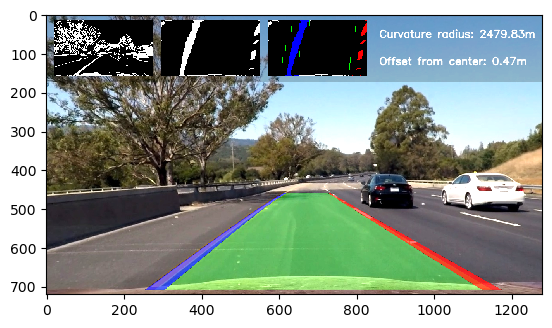

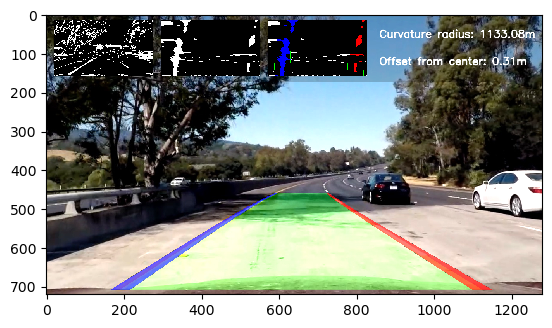

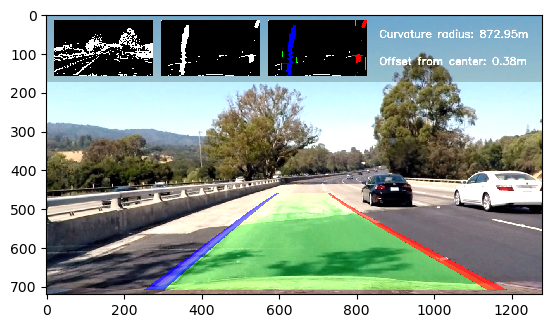

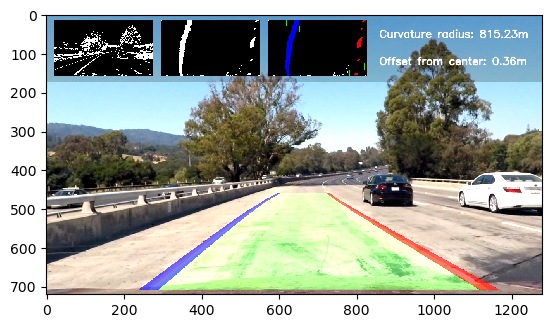

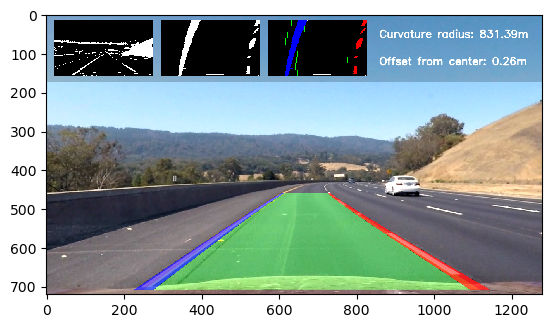

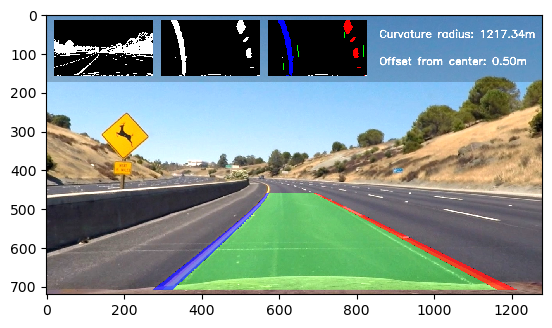

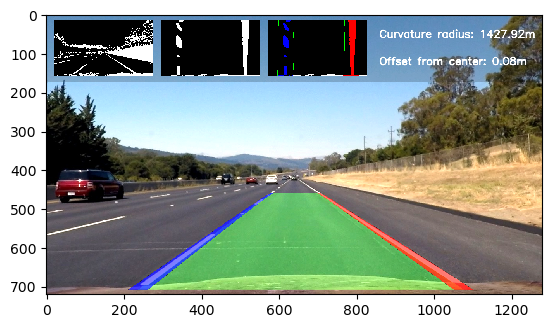

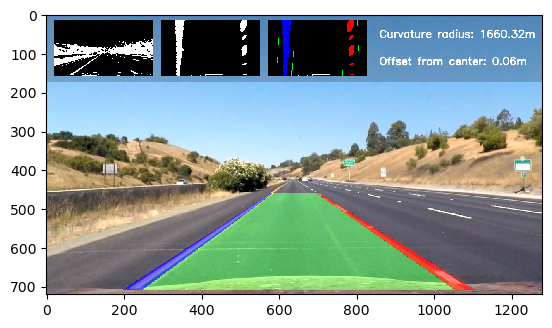

In [9]:
import cv2
import os
import matplotlib.pyplot as plt
from calibration_utils import calibrate_camera, undistort
from binarization_utils import binarize
from perspective_utils import birdeye
from line_utils import get_fits_by_sliding_windows, draw_back_onto_the_road, Line, get_fits_by_previous_fits
from moviepy.editor import VideoFileClip
import numpy as np
from globals import xm_per_pix, time_window


processed_frames = 0                    # counter of frames processed (when processing video)
line_lt = Line(buffer_len=time_window)  # line on the left of the lane
line_rt = Line(buffer_len=time_window)  # line on the right of the lane


def prepare_out_blend_frame(blend_on_road, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter):
    """
    Prepare the final pretty pretty output blend, given all intermediate pipeline images

    :param blend_on_road: color image of lane blend onto the road
    :param img_binary: thresholded binary image
    :param img_birdeye: bird's eye view of the thresholded binary image
    :param img_fit: bird's eye view with detected lane-lines highlighted
    :param line_lt: detected left lane-line
    :param line_rt: detected right lane-line
    :param offset_meter: offset from the center of the lane
    :return: pretty blend with all images and stuff stitched
    """
    h, w = blend_on_road.shape[:2]

    thumb_ratio = 0.2
    thumb_h, thumb_w = int(thumb_ratio * h), int(thumb_ratio * w)

    off_x, off_y = 20, 15

    # add a gray rectangle to highlight the upper area
    mask = blend_on_road.copy()
    mask = cv2.rectangle(mask, pt1=(0, 0), pt2=(w, thumb_h+2*off_y), color=(0, 0, 0), thickness=cv2.FILLED)
    blend_on_road = cv2.addWeighted(src1=mask, alpha=0.2, src2=blend_on_road, beta=0.8, gamma=0)

    # add thumbnail of binary image
    thumb_binary = cv2.resize(img_binary, dsize=(thumb_w, thumb_h))
    thumb_binary = np.dstack([thumb_binary, thumb_binary, thumb_binary]) * 255
    blend_on_road[off_y:thumb_h+off_y, off_x:off_x+thumb_w, :] = thumb_binary

    # add thumbnail of bird's eye view
    thumb_birdeye = cv2.resize(img_birdeye, dsize=(thumb_w, thumb_h))
    thumb_birdeye = np.dstack([thumb_birdeye, thumb_birdeye, thumb_birdeye]) * 255
    blend_on_road[off_y:thumb_h+off_y, 2*off_x+thumb_w:2*(off_x+thumb_w), :] = thumb_birdeye

    # add thumbnail of bird's eye view (lane-line highlighted)
    thumb_img_fit = cv2.resize(img_fit, dsize=(thumb_w, thumb_h))
    blend_on_road[off_y:thumb_h+off_y, 3*off_x+2*thumb_w:3*(off_x+thumb_w), :] = thumb_img_fit

    # add text (curvature and offset info) on the upper right of the blend
    mean_curvature_meter = np.mean([line_lt.curvature_meter, line_rt.curvature_meter])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(blend_on_road, 'Curvature radius: {:.02f}m'.format(mean_curvature_meter), (860, 60), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(blend_on_road, 'Offset from center: {:.02f}m'.format(offset_meter), (860, 130), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)

    return blend_on_road


def compute_offset_from_center(line_lt, line_rt, frame_width):
    """
    Compute offset from center of the inferred lane.
    The offset from the lane center can be computed under the hypothesis that the camera is fixed
    and mounted in the midpoint of the car roof. In this case, we can approximate the car's deviation
    from the lane center as the distance between the center of the image and the midpoint at the bottom
    of the image of the two lane-lines detected.

    :param line_lt: detected left lane-line
    :param line_rt: detected right lane-line
    :param frame_width: width of the undistorted frame
    :return: inferred offset
    """
    if line_lt.detected and line_rt.detected:
        line_lt_bottom = np.mean(line_lt.all_x[line_lt.all_y > 0.95 * line_lt.all_y.max()])
        line_rt_bottom = np.mean(line_rt.all_x[line_rt.all_y > 0.95 * line_rt.all_y.max()])
        lane_width = line_rt_bottom - line_lt_bottom
        midpoint = frame_width / 2
        offset_pix = abs((line_lt_bottom + lane_width / 2) - midpoint)
        offset_meter = xm_per_pix * offset_pix
    else:
        offset_meter = -1

    return offset_meter


def process_pipeline(frame, keep_state=True):
    """
    Apply whole lane detection pipeline to an input color frame.
    :param frame: input color frame
    :param keep_state: if True, lane-line state is conserved (this permits to average results)
    :return: output blend with detected lane overlaid
    """

    global line_lt, line_rt, processed_frames

    # undistort the image using coefficients found in calibration
    img_undistorted = undistort(frame, mtx, dist, verbose=False)

    # binarize the frame s.t. lane lines are highlighted as much as possible
    img_binary = binarize(img_undistorted, verbose=False)

    # compute perspective transform to obtain bird's eye view
    img_birdeye, M, Minv = birdeye(img_binary, verbose=False)

    # fit 2-degree polynomial curve onto lane lines found
    if processed_frames > 0 and keep_state and line_lt.detected and line_rt.detected:
        line_lt, line_rt, img_fit = get_fits_by_previous_fits(img_birdeye, line_lt, line_rt, verbose=False)
    else:
        line_lt, line_rt, img_fit = get_fits_by_sliding_windows(img_birdeye, line_lt, line_rt, n_windows=9, verbose=False)

    # compute offset in meter from center of the lane
    offset_meter = compute_offset_from_center(line_lt, line_rt, frame_width=frame.shape[1])

    # draw the surface enclosed by lane lines back onto the original frame
    blend_on_road = draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, keep_state)

    # stitch on the top of final output images from different steps of the pipeline
    blend_output = prepare_out_blend_frame(blend_on_road, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter)

    processed_frames += 1

    return blend_output


if __name__ == '__main__':

    # first things first: calibrate the camera
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(calib_images_dir='camera_cal')

    mode = 'images'

    if mode == 'video':

        selector = 'project'
        clip = VideoFileClip('{}_video.mp4'.format(selector)).fl_image(process_pipeline)
        clip.write_videofile('out_{}_{}.mp4'.format(selector, time_window), audio=False)

    else:

        test_img_dir = 'test_images'
        for test_img in os.listdir(test_img_dir):

            frame = cv2.imread(os.path.join(test_img_dir, test_img))

            blend = process_pipeline(frame, keep_state=False)

            cv2.imwrite('output_images/{}'.format(test_img), blend)

            plt.imshow(cv2.cvtColor(blend, code=cv2.COLOR_BGR2RGB))
            plt.show()
